# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 22

**Author 1 (sciper):** Alexander Pisarewski (269689)  
**Author 2 (sciper):** Guillaume Champain (261737)   
**Author 3 (sciper):** Adrien AMOROS (322927)   

**Release date:** 23.04.2021 
**Due date:** 07.05.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [9]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [10]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import  optimize

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

#### Discussion
The Bayes method consists in classifying several classes by using multi-dimensional Gaussian law. A discriminant function is thus used for all of the classes. In order to find the separation betweem two classes, the discriminant functions are used pairwise : the lines separating the classes are the points where the probability to be in one class or the other is the same. Each discriminant function is given as  :
$$ g_i(x) = -\frac{1}{2}(x-\mu)^T \Sigma^{-1}_i (x-\mu_i) + \ln P(w_i) + c_i$$
And the separation curves between two classes i and j as $ g_i(x)-g_j(x)$.
The classes here having the same number of samples, the $\ln P(w_i)$ term cancels out when doing the substraction. The constant term $c_i$is taken to be $c_{i} = log(\frac{1}{2\pi |\Sigma_i|^{1/2}}) $
The mean values and covariances are hence found from the three given datasets, and a function is created that returns for one y-coordinate, its corresponding x-coordinate where the equation of the separation curve cancels.
A vector is hence created taking a grid of values that fits all the dataset inside.
Two plots are created : one with the three complete curves separating every pair of datasets, and one with the three curves the three datasets in a "cleaner" fashion.

In [11]:
#Calculate means and covariances
mean_a=np.mean(a,axis=0)
cov_a=np.cov(a,rowvar=False)

mean_b=np.mean(b,axis=0)
cov_b=np.cov(b,rowvar=False)

mean_c=np.mean(c,axis=0)
cov_c=np.cov(c,rowvar=False)


def g(x,x_1,mean1,cov1,mean2,cov2):
    """
        Function that returns the root of the separation curve equation, for 1 point
        Arguments :
        - x : variable of the equation
        - x1 : point at which we find the root
        - mean1 : mean of the first dataset
        - cov1 : covariance of the first dataset
        - mean2 : mean of the second dataset
        - cov2 : covariance of the second dataset
    """
    vec=np.array([x,x_1]).T
    const1 =np.log(1/(2*np.pi*np.linalg.det(cov1)**0.5))
    const2 =np.log(1/(2*np.pi*np.linalg.det(cov2)**0.5))
    res=-0.5*(vec-mean1)@np.linalg.inv(cov1)@(vec-mean1).T-(-0.5*(vec-mean2)@np.linalg.inv(cov2)@(vec-mean2).T) + const1-const2
    return res


#Initialization of the roots vector
roots1=[]
roots2=[]
roots3=[]

# Grid defined for roots finding
y_range=np.arange(-7,7,0.1)
for x_1 in y_range :
    result1=optimize.fsolve(g,x0=0,args=(x_1,mean_a,cov_a,mean_b,cov_b))
    result2=optimize.fsolve(g,x0=0,args=(x_1,mean_b,cov_b,mean_c,cov_c))
    result3=optimize.fsolve(g,x0=0,args=(x_1,mean_a,cov_a,mean_c,cov_c))
    roots1=np.append(roots1,result1)
    roots2=np.append(roots2,result2)
    roots3=np.append(roots3,result3)


idx=(np.where(abs(roots1-roots2)<1))
idx=idx[0][0]+1


#Plotting
fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].scatter(a[:,0],a[:,1],label='a')
ax[0].scatter(b[:,0],b[:,1],label='b')
ax[0].scatter(c[:,0],c[:,1],label='c')
ax[0].plot(roots1[:idx],y_range[:idx],color='yellow',label='g_a-g_b')
ax[0].plot(roots2[idx:],y_range[idx:],color='grey',label='g_b-g_c')
ax[0].plot(roots3[:idx],y_range[:idx],color='pink',label='g_a-g_c')
ax[0].set_xlim([-15 ,15])
ax[0].set_ylim([-7 ,7])
ax[0].set_title('Three classes dataset with separation curves')
ax[0].legend(loc='lower right')

ax[1].scatter(a[:,0],a[:,1],label='a')
ax[1].scatter(b[:,0],b[:,1],label='b')
ax[1].scatter(c[:,0],c[:,1],label='c')
ax[1].plot(roots1,y_range,color='yellow',label='g_a-g_b')
ax[1].plot(roots2,y_range,color='grey',label='g_b-g_c')
ax[1].plot(roots3,y_range,color='pink',label='g_a-g_c')
ax[1].set_xlim([-15 ,15])
ax[1].set_ylim([-7 ,7])
ax[1].set_title('Three classes dataset with full separation curves')
ax[1].legend(loc='lower right')


IndentationError: unexpected indent (<ipython-input-11-7b7e776bbda3>, line 23)

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

#### Explanation of classification by Mahalanobis distance

In a second time, to take multivariate variable into account, we will use the Mahalanobis distance to classify a point in class a or b.
Mahalonobis distance is the distance between a point and a distribution. And not between two distinct points. It is effectively a multivariate equivalent of the Euclidean distance. Its analytical expression is :
$$
d_{m} = \sqrt{(x- \mu_{i})\Sigma^{-1}(x- \mu_{i})}
$$
Where $x$ is the vector of the observation, $\mu_{i}$ is the vector of mean values of the distribution and $\Sigma^{-1}$ is the inverse covariance matrix of the distribution.

Firstly, to split the plane through class a and b we created a meshgrid of the region of interest. Knowing that the
most probable class is the one that maximizes the discriminant function $g_i(x)$ , it means minimizes the Mahalanobis distance, we selected the shortest distance computed between distribution a and b for each point of the plane.
Afterwards, we plotted the separation line obtained from our plane classification.




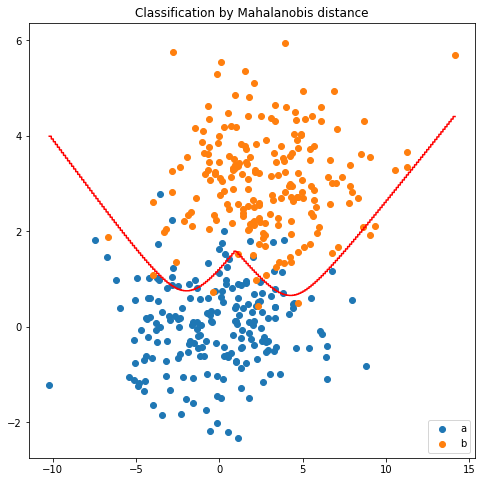

In [4]:
# Add your implementation and discussion
import matplotlib.pyplot as plt
import numpy as np

#We can assume data distribustions as gaussian distribution

#Function to compute the Mahalanobis Distance between each row of x and the data  
def mahalanobis(x, data, cov=None):
    """
    x    : vector or matrix of data
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data,axis=0)
    if not cov:
        cov = np.cov(data,rowvar=False)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal_square = np.dot(left_term, x_minus_mu)
    mahal = np.sqrt(mahal_square)
    return mahal

data_2=np.vstack([a,b])

x_min = data_2[:,0].min()
x_max = data_2[:,0].max()
y_min = data_2[:,1].min()
y_max = data_2[:,1].max()

# Create meshgrid of interest space
length_mesh = 200
xx, yy = np.meshgrid(np.linspace(x_min , x_max, length_mesh),np.linspace(y_min, y_max, length_mesh))

result = []

#the most probable class is the one that minimizes the Mahalanobis distance
for x,y in zip(np.sort(xx.ravel()),np.sort(yy.ravel())) :
    distance_a = mahalanobis([x,y],a)
    distance_b = mahalanobis([x,y],b)
    result.append(np.minimum(distance_a,distance_b))


x_range = np.linspace(x_min , x_max, length_mesh**2)
# Plotting of the two classes
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(a[:,0],a[:,1],label='a')
ax.scatter(b[:,0],b[:,1],label='b')
ax.plot(x_range,result,color='red')
ax.set_title('Classification by Mahalanobis distance')
ax.legend(loc='lower right')

#### Outcomes differences between two classification methods

In the cell below, we tested if the classifications among the two methods used previously lead to the same outcome.
For the "traditional" Bayes method we will compare the discriminant functions of distribution a and b. According to $g_a-g_b$ sign on can link the random point to class a or b.
For the classification thanks to Mahalabonis distance, we assigned a point to a class where its distance to the latter class is smaller than the other.

For some random points (10) of the plane, we can note the same result regardless of classification methods. But if we increase the number of test vectors, we will obtain a little difference between the 2 methods but not substantially relevant.

In [5]:
import random

# Check the difference in classification of some random points between traditionnal "Bayes method" and "Mahalanobis distance"

def classification_vectors(rand_vectors) :
    Bayes_classification = []
    for i in rand_vectors:
        result_sub = g(i[0],i[1],mean_a,cov_a,mean_b,cov_b)
        if (result_sub < 0):
            Bayes_classification.append('b')
        elif (result_sub > 0):
            Bayes_classification.append('a')
        else:
            Bayes_classification.append('NC')
        
    Mahalanobis_classification = []
    for i in rand_vectors:
        distance_a = mahalanobis(i,a)
        distance_b = mahalanobis(i,b)
        if (distance_a > distance_b):
            Mahalanobis_classification.append('b')
        elif (distance_a < distance_b):
            Mahalanobis_classification.append('a')
        else:
            Mahalanobis_classification.append('NC')
    
    return Bayes_classification, Mahalanobis_classification

random.seed(3)
points_numb_test = 10
x_rand_test = [random.randint(-12,17) for x in range(points_numb_test)]
y_rand_test = [random.randint(-5,7) for x in range(points_numb_test)]
rand_vectors_test = [[x,y] for x,y in zip(x_rand_test,y_rand_test)]

Bayes_classification_test, Mahalanobis_classification_test = classification_vectors(rand_vectors_test)

print('10 random testing vectors:' ,rand_vectors_test)
print('Classification using the "complete" Bayes method = ',Bayes_classification_test)
print('Classification using Mahalanobis distance = ',Mahalanobis_classification_test)    


points_numb = 10000
x_rand = [random.randint(-12,17) for x in range(points_numb)]
y_rand = [random.randint(-5,7) for x in range(points_numb)]
rand_vectors = [[x,y] for x,y in zip(x_rand,y_rand)]

Bayes_classification, Mahalanobis_classification = classification_vectors(rand_vectors)

diff_num = np.count_nonzero(np.where(np.asarray(Bayes_classification)!= np.asarray(Mahalanobis_classification),1,0))

print('Difference of classification under {} random points = {}'.format(points_numb,diff_num))

10 random testing vectors: [[-5, -4], [6, 4], [5, -5], [-8, 2], [-1, -1], [17, 3], [7, -2], [3, -2], [8, 6], [6, 2]]
Classification using the "complete" Bayes method =  ['a', 'b', 'a', 'a', 'a', 'b', 'a', 'a', 'b', 'b']
Classification using Mahalanobis distance =  ['a', 'b', 'a', 'a', 'a', 'b', 'a', 'a', 'b', 'b']
Difference of classification under 10000 random points = 17


---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [6]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [7]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

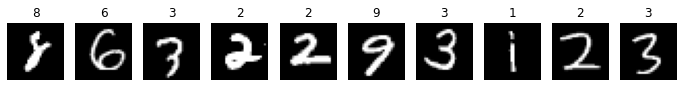

In [8]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

###  Implementation Details 

#### Data Preprocessing: 
For the labels, one hot label encoding is implemented in order to efficiently count the amount of error in the train and test set. Moreover, the dataset is standardized by substracting its mean and dividing by its standard deviation. 

#### The Multi Layer Perceptron 
The MLP has been implemented using the pytorch library.  The following properties are implemented:

1. A module implementing a Multi Layer perceptron with one layer of 100 units
2. A relu activation layer to implement non-linearity

#### Training: 
For training, the following structure is used: 

1. Mean square error loss
2. Stochastic gradient descent for backpropagation 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim 
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [10]:
class MLP(nn.Module):
    def __init__(self, nb_hidden:int):
        super().__init__()
        """
        Multi Layer Perceptron Module 

        Arguments: 
        nb_hidden [int]: Dimension of the hidden layer 

        Attributes: 
        fc1: First fully connected linear layer (28*28) -->nb_hidden 
        fc2: Second fully connected linear layer (nb_hidden) --> 10 

        """
        # First fully connected linear layer (784)->(100)
        self.fc1 = nn.Linear(28*28, nb_hidden) 
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 28*28)))
        x = self.fc2(x)
        return x


def train_model(model:nn.Module, train_input:torch.tensor, train_target:torch.tensor, mini_batch_size: int, nb_epochs: int = 20,verbose:int =0)-> [np.ndarray,np.ndarray]:

    """
    Training model function, plots the final train and test error 

    Attributes: 
    criterion: MSE Loss
    Optimizer: SGD 

    Parameters: 
    model [nn.Module]: Pytorch module wished to be trained
    train_input [torch.tensor]: input images with dimension (n,1,28,28) with n the number of images
    train_target [torch.tesnor]: input labels with dimension(n,1)
    mini_batch_size [int]: Batch Size
    nb_epochs [int]: amount of epochs,  20 by default
    verbose[int]: If >0, displays the train and test error for each epoch. 

    Returns: 
    train_error [numpy.ndarray]: array with train error pourcentage with dimension (1,nb_epoch)
    test_error [numpy.ndarray]:array with train error pourcentage with dimension (1,nb_epoch)
    """

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr = 1e-1)

    train_error=[]
    test_error=[]
    for e in range(nb_epochs):
        acc_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        nb_test_errors = compute_nb_errors(model, test_input, test_target, mini_batch_size)
        nb_train_errors = compute_nb_errors(model, train_input, train_target, mini_batch_size)

        train_error=np.append(train_error,(100 * nb_train_errors) / train_input.size(0))
        test_error=np.append(test_error,(100 * nb_test_errors) / test_input.size(0))


        if verbose>0:
            print(e,' Train error: {:0.2f}%  Test error: {:0.2f}% '.format((100 * nb_train_errors) / train_input.size(0),
                                                                        (100 * nb_test_errors) / test_input.size(0)))

        if e==nb_epochs-1:
            print('Final Train error: {:0.2f}%  Test error: {:0.2f}% '.format((100 * nb_train_errors) / train_input.size(0),
                                                                        (100 * nb_test_errors) / test_input.size(0)))
    return train_error,test_error
        
           

def compute_nb_errors(model:nn.Module, input:torch.tensor, target:torch.tensor, mini_batch_size:int)->int:
    """
    Computes the absolute number of errors of a model with respect to an input and a target 

    Parameters:
    model [nn.Module]: Model to be used
    input[torch.tensor]: input images with dimension (n,1,28,28) with n the number of images
    target [torch.tesnor]: input labels with dimension(n,1)
    mini_batch_size [int]: Batch Size

    Returns:
    nb_errors[int]: Absolute number of errors where the target differs from the predicted value

    """
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        #print(predicted_classes)
        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

def convert_to_one_hot_labels(input:torch.tensor, target:torch.tensor)->torch.tensor:
    """
    Conversion to one hot labels

    Parameters: 
    input[torch.tensor]: input images with dimension (n,1,28,28) with n the number of images
    target [torch.tesnor]: input labels with dimension(n,1)

    Returns:
    tmp [torch.tensor]: One hot label tensor with dimension (n,c) with n the number of data points and c the number of classes.    
    """

    tmp = input.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

0  Train error: 8.98%  Test error: 8.39% 
1  Train error: 6.97%  Test error: 6.66% 
2  Train error: 6.06%  Test error: 5.73% 
3  Train error: 5.45%  Test error: 5.35% 
4  Train error: 5.03%  Test error: 4.99% 
5  Train error: 4.64%  Test error: 4.71% 
6  Train error: 4.33%  Test error: 4.58% 
7  Train error: 4.07%  Test error: 4.42% 
8  Train error: 3.92%  Test error: 4.30% 
9  Train error: 3.75%  Test error: 4.19% 
10  Train error: 3.63%  Test error: 4.04% 
11  Train error: 3.48%  Test error: 3.96% 
12  Train error: 3.37%  Test error: 3.93% 
13  Train error: 3.24%  Test error: 3.87% 
14  Train error: 3.17%  Test error: 3.77% 
15  Train error: 3.10%  Test error: 3.71% 
16  Train error: 3.05%  Test error: 3.66% 
17  Train error: 2.97%  Test error: 3.61% 
18  Train error: 2.91%  Test error: 3.55% 
19  Train error: 2.87%  Test error: 3.49% 
Final Train error: 2.87%  Test error: 3.49% 


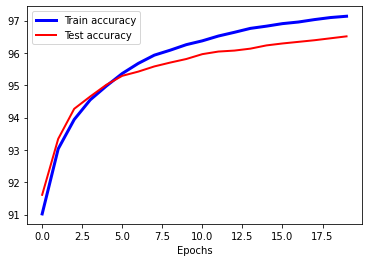

In [11]:

# Preprocessing 
# Converting data into pytorch tensor with dimension (n,1,28,28) with n the number of data points
train_input =torch.tensor(extract_data(train_images_path, image_shape, train_set_size)).view(-1,1,28,28).float()
test_input =torch.tensor(extract_data(test_images_path, image_shape, test_set_size)).view(-1,1,28,28).float()
train_target = torch.tensor(extract_labels(train_labels_path, train_set_size))
test_target = torch.tensor(extract_labels(test_labels_path, test_set_size))

# One hot encoding of the labels
train_target=convert_to_one_hot_labels(train_input, train_target)
test_target=convert_to_one_hot_labels(test_input, test_target)

# Normalization of the data 
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)


# Building and training the Model 
mini_batch_size = 100
model = MLP(100)
train_error,test_error=train_model(model, train_input, train_target, mini_batch_size,verbose=1)


# Plotting the accuracy 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,train_error.shape[0]), 100-train_error, color='blue', linewidth=3,label='Train accuracy')
ax.plot(range(0,test_error.shape[0]), 100-test_error, color='red', linewidth=2,label='Test accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()

### Discussion

Once the model is trained with 20 epochs and a batch size of 100, it reaches an accuracy of 96.58% on the testing set. This is very nice for such an easy model with just one layer. 
On the plot one can notice a clear correlation between the testing and training accuracy for a low amount of epochs. However when the amount of epochs increase, the train and test error diverge more and more. This is due to overfitting the training data. The training set is fairly large so the real effect of overfitting is not very clear. So the following figure shows the test and train accuracy for a reduced training set of 1000 data points and 200 epochs. One notices that at some point, the train accuracy is nearly 100% while the test accuracy stagnates at 90%. This shows that the training set does not represent fully the data, which is why it is preferable to train the data with a large training set which is as diverse as possible.

Final Train error: 0.00%  Test error: 10.96% 


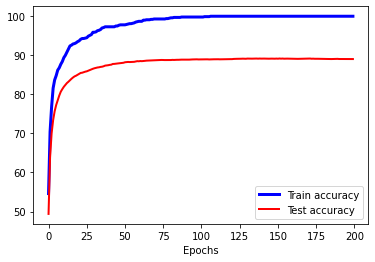

In [12]:
# Example for 1000 traingng data 
nb_e=200
mini_batch_size=100
model = MLP(100)
train_error,test_error=train_model(model, train_input.narrow(0,0,1000), train_target.narrow(0,0,1000), mini_batch_size,nb_epochs=nb_e,verbose=0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,train_error.shape[0]), 100-train_error, color='blue', linewidth=3,label='Train accuracy')
ax.plot(range(0,test_error.shape[0]), 100-test_error, color='red', linewidth=2,label='Test accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()